# Mannheim Bikesharing Rental Analysis

Introduction to Data Science and Machine Learning    XIA Mingxiang_7374120

### Load functional package and read data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=DeprecationWarning)

from datetime import date, time, datetime, timedelta
from dateutil import parser

%matplotlib inline

In [2]:
df_raw = pd.read_csv(r'C:\Users\admin\Desktop\mannheim.csv')
hourdf = pd.read_csv(r'C:\Users\admin\Desktop\mannheim_rental amount in hours.csv')
bike_utilization = pd.read_csv(r'C:\Users\admin\Desktop\mannheim_bike utilization.csv')

In [3]:
df_raw.head()

,day,year,month,weekday,is_weekend,is_holiday,season,time,hour,b_number,...,orig_lng,dest_lat,dest_lng,air_pressure,cloud_coverage,humidity,sunshine_duration,temperature,vapor_pressure,wind_speed
0,2019/1/20,2019,1,7,1,0,4,12:38:00,12,42827,...,8.470716,49.498946,8.467224,NaN,NaN,NaN,6.5,-4.0,NaN,NaN
1,2019/1/20,2019,1,7,1,0,4,13:15:00,13,42827,...,8.467224,49.493002,8.470325,NaN,NaN,NaN,6.5,-4.0,NaN,NaN
2,2019/1/20,2019,1,7,1,0,4,13:22:00,13,42827,...,8.470325,49.487939,8.478742,NaN,NaN,NaN,6.5,-4.0,NaN,NaN
3,2019/1/20,2019,1,7,1,0,4,14:33:00,14,42827,...,8.478742,49.479347,8.478248,NaN,NaN,NaN,6.5,-4.0,NaN,NaN
4,2019/1/20,2019,1,7,1,0,4,15:14:00,15,42827,...,8.477658,49.479493,8.471188,NaN,NaN,NaN,6.5,-4.0,NaN,NaN


### Data preprocessing

In [4]:
df_raw['day']=pd.to_datetime(df_raw['day'])
df_raw.info()
# Reset the Dtype of 'day' column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141728 entries, 0 to 141727
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   day                141728 non-null  datetime64[ns]
 1   year               141728 non-null  int64         
 2   month              141728 non-null  int64         
 3   weekday            141728 non-null  int64         
 4   is_weekend         141728 non-null  int64         
 5   is_holiday         141728 non-null  int64         
 6   season             141728 non-null  int64         
 7   time               141728 non-null  object        
 8   hour               141728 non-null  int64         
 9   b_number           141728 non-null  int64         
 10  city               141728 non-null  object        
 11  trip_duration      141728 non-null  int64         
 12  price              141728 non-null  float64       
 13  orig_lat           141728 non-null  float64 

**Indicator Description:**  
- day: date in the form of yyyy/mm/dd
- year
- month
- weekday: 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 = Saturday, 7 = Sunday
- is_weekend: 1 = weekend, 0 = working day
- is_holiday: 1 = holiday, 0 = non-holiday, including weekend if holidays are next to weekend, in order to better simulate the reallife traveling situation of citizens
- season: 1 = Spring, 2 = Summer, 3 = Autumn, 4 = Winter
- temperature: mean temperature at 2m above ground in ºC
- humidity: mean of relative humidity at 2m above ground in %
- wind_speed: wind speed at ca. 10m above ground
- air_pressure: mean air pressure at station level in hpa
- cloud_coverage: mean cloud coverage in eighths
- vapor_pressure: mean vapor pressure in hpa
- sunshine_duration: sunshine duration in hours

**Research Question:**
- What is the relationship between the rental amount of bikes and these above indicators? What is the trend?
- Forecast the demand of shared bikes through these features in the test cluster.

In [5]:
df = df_raw.fillna(method='ffill').fillna(method='bfill')

# Missing value processing
# It's not recommended that the average, median value of weather conditions be used to fill in the missing values, 
# because the weather changes greatly over a certain period of time. 
# Therefore, I chose to fill in the missing values with weather conditions for the adjacent dates to minimize the error range.

In [6]:
df.describe()

# We can confirm that the missing value of the Dataframe has been filled through following describe table.
# Standard deviations of all features are within a reasonable range, without a large number of obvious anomalous values.

,year,month,weekday,is_weekend,is_holiday,season,hour,b_number,trip_duration,price,...,orig_lng,dest_lat,dest_lng,air_pressure,cloud_coverage,humidity,sunshine_duration,temperature,vapor_pressure,wind_speed
count,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,...,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,141728.000000,141728.00000
mean,2019.033663,6.859936,3.734774,0.213578,0.032104,2.384815,13.165782,222472.729277,15.834443,1.215854,...,8.472377,49.485246,8.472559,1004.673059,5.473881,70.804561,6.438330,13.749755,11.198966,2.63729
std,0.180361,3.049379,1.895262,0.409834,0.176276,1.005098,5.288700,192804.394939,19.571423,0.921927,...,0.024089,0.050578,0.040711,8.548636,2.391338,13.782632,4.911954,7.003673,3.990429,1.08529
min,2019.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,20234.000000,3.000000,1.000000,...,7.746191,31.294778,7.103879,972.310000,0.000000,35.960000,0.000000,-4.500000,3.200000,0.90000
25%,2019.000000,5.000000,2.000000,0.000000,0.000000,2.000000,9.000000,43496.000000,7.000000,1.000000,...,8.463303,49.480115,8.463303,999.400000,4.000000,60.500000,1.650000,8.500000,7.700000,1.80000
50%,2019.000000,7.000000,4.000000,0.000000,0.000000,2.000000,14.000000,44312.000000,11.000000,1.000000,...,8.469535,49.485919,8.469493,1004.870000,6.300000,70.790000,6.417000,14.100000,11.100000,2.40000
75%,2019.000000,9.000000,5.000000,0.000000,0.000000,3.000000,17.000000,430183.000000,16.000000,1.000000,...,8.476650,49.493002,8.478277,1009.640000,7.500000,82.210000,10.700000,18.900000,14.400000,3.20000
max,2020.000000,12.000000,7.000000,1.000000,1.000000,4.000000,23.000000,430399.000000,179.000000,8.500000,...,8.857224,51.244237,20.545836,1033.210000,8.000000,100.000000,15.483000,29.300000,21.000000,7.30000


### Observe the overall trend

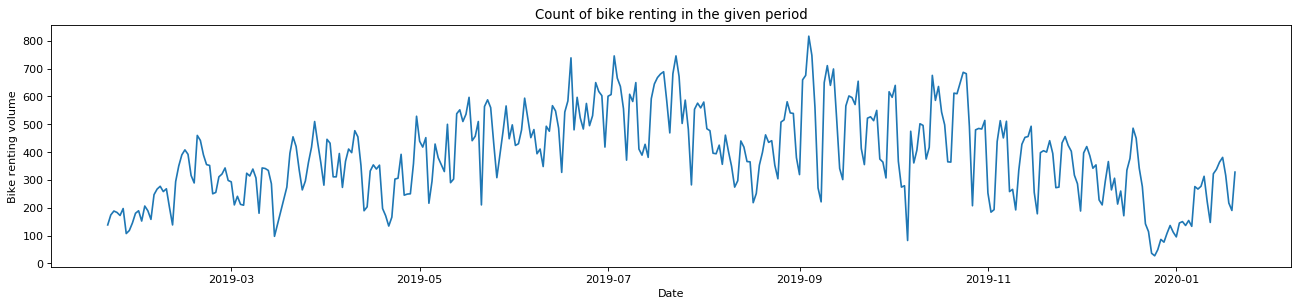

In [7]:
bike_volume_by_date = df.groupby('day')['day'].count()

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)

ax.plot(bike_volume_by_date)
ax.set_xlabel('Date')
ax.set_ylabel("Bike renting volume")
ax.set_title('Count of bike renting in the given period')

plt.show()

# Distribution of the amount of bike-sharing rentals in the given period

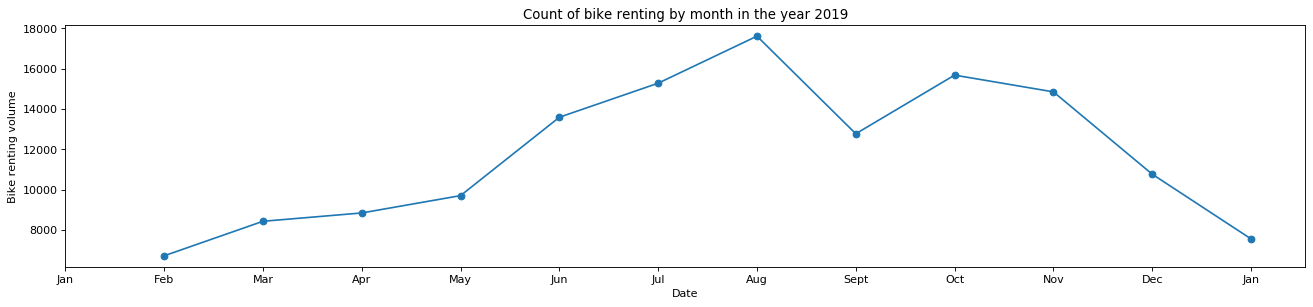

In [8]:
bike_volume_by_month = df.groupby('month')['month'].count()

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)

ax.plot(bike_volume_by_month,'o-')
ax.set_xlabel('Date')
ax.set_ylabel("Bike renting volume")
ax.set_xticks(list(range(13)))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Jan'])
ax.set_title('Count of bike renting by month in the year 2019')

plt.show()

# Create a line chart indicating monthly bike rental situation in the given period

Compared with the above two graphs about the annual change of bike rental volume:  
- The number of shared bike rental has been growing from January to July, and it peaked in July.
- The rental amount was descending from July to August, presumably due to high outdoor temperatures in summer.
- From August to October, the number of shared bike rentals in Mannheim was unstable, with the highest rental volume in early September.
- The number of bike rentals decreased from October to December and reached its lowest point around the Christmas holiday.

In [9]:
df_hour_count = df.groupby('hour')['day'].count().reset_index('hour')
df_hour_count.rename(columns={'day':'count of hour'},inplace=True)
df_hour_count

,hour,count of hour
0,0,2215
1,1,1529
2,2,1053
3,3,737
4,4,1178
5,5,3890
6,6,6234
7,7,6706
8,8,6609
9,9,6840


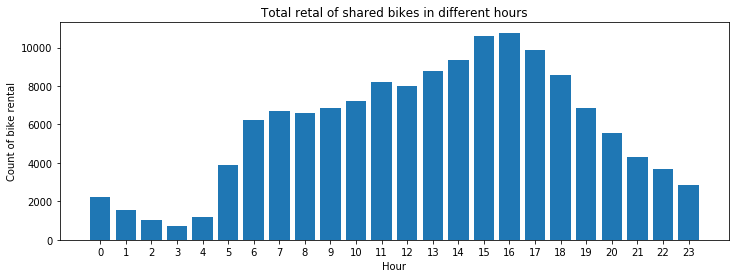

In [10]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
fig.set_size_inches(12,4)

plt.bar(df_hour_count['hour'], df_hour_count['count of hour'])
plt.title('Total retal of shared bikes in different hours',fontsize=12)
plt.xlabel('Hour')
plt.ylabel('Count of bike rental')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

plt.show()

# Bikes are used more during off-duty hours than during office hours. 
# In the afternoon, bikes should be appropriately transported to business areas and with high demand for bikes.

### Observe the distribution of weather-related indicators

Text(0.5, 1.0, 'Distribution of sunshine duration')

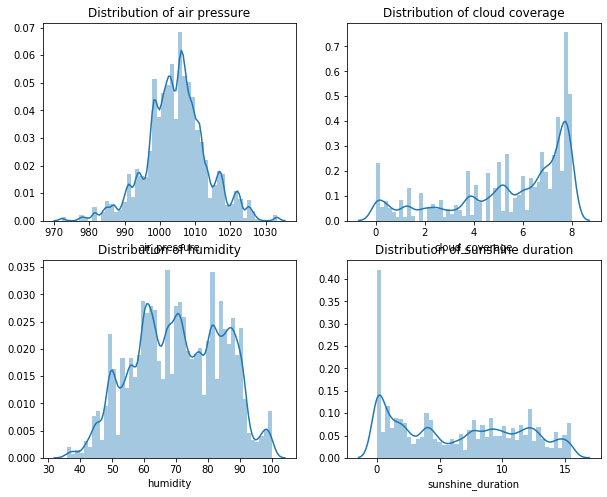

In [11]:
fig=plt.figure()
fig.set_size_inches(10,8)

ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

sns.distplot(df['air_pressure'],ax=ax1)
sns.distplot(df['cloud_coverage'],ax=ax2)
sns.distplot(df['humidity'],ax=ax3)
sns.distplot(df['sunshine_duration'],ax=ax4)

ax1.set_title('Distribution of air pressure')
ax2.set_title('Distribution of cloud coverage')
ax3.set_title('Distribution of humidity')
ax4.set_title('Distribution of sunshine duration')

# Create displots to check weather data for outliers.
# Have a general picture of the distribution of different variables, and then generate frequency tables for them. 
# Draw histograms for each numerical variable.

Text(0.5, 1.0, 'Distribution of wind speed')

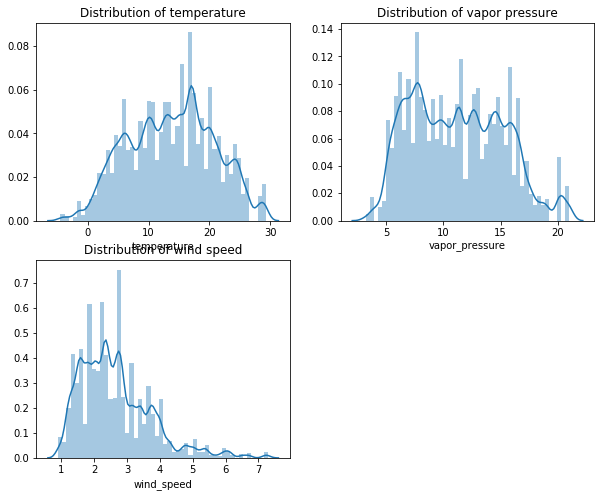

In [12]:
fig=plt.figure()
fig.set_size_inches(10,8)

ax5=fig.add_subplot(2,2,1)
ax6=fig.add_subplot(2,2,2)
ax7=fig.add_subplot(2,2,3)

sns.distplot(df['temperature'],ax=ax5)
sns.distplot(df['vapor_pressure'],ax=ax6)
sns.distplot(df['wind_speed'],ax=ax7)

ax5.set_title('Distribution of temperature')
ax6.set_title('Distribution of vapor pressure')
ax7.set_title('Distribution of wind speed')

### Observe the rental density distribution

In [13]:
df_count = df.groupby(['day'])['day'].count().reset_index(name='count')
df_count = pd.merge(df_count,df,on='day',how='outer') 

df_count = df_count.drop_duplicates(['day'])
df_count = df_count.reset_index(drop=True)

df_count.drop(['time', 'hour','b_number','trip_duration','orig_lat','orig_lng','dest_lat','dest_lng','price'], axis=1,inplace=True)

df_price = df.groupby(['day'])['price'].sum().reset_index(name='price')
df_count = pd.merge(df_price,df_count,on='day',how='inner')

df_count

,day,price,count,year,month,weekday,is_weekend,is_holiday,season,city,air_pressure,cloud_coverage,humidity,sunshine_duration,temperature,vapor_pressure,wind_speed
0,2019-01-20,159.0,138,2019,1,7,1,0,4,mannheim,999.36,6.3,81.67,6.500,-4.0,3.9,2.1
1,2019-01-21,195.0,174,2019,1,1,0,0,4,mannheim,999.36,6.3,81.67,7.800,-4.5,3.9,2.1
2,2019-01-22,225.5,188,2019,1,2,0,0,4,mannheim,999.36,6.3,81.67,0.000,-3.3,3.9,2.1
3,2019-01-23,190.5,183,2019,1,3,0,0,4,mannheim,988.40,8.0,70.29,0.417,-1.5,3.9,2.3
4,2019-01-24,187.0,172,2019,1,4,0,0,4,mannheim,998.29,7.9,72.96,0.000,-2.4,3.8,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2020-01-16,438.0,381,2020,1,4,0,0,4,mannheim,1014.38,2.8,73.08,7.517,10.0,9.0,2.4
359,2020-01-17,407.5,316,2020,1,5,0,0,4,mannheim,1008.70,4.5,81.50,1.750,6.3,7.8,3.1
360,2020-01-18,236.5,217,2020,1,6,1,0,4,mannheim,1014.95,6.5,79.88,2.583,4.7,6.8,3.6
361,2020-01-19,202.0,190,2020,1,7,1,0,4,mannheim,1024.70,7.6,87.79,0.933,2.9,6.6,2.3


Text(0.5, 1.0, 'Distribution of count')

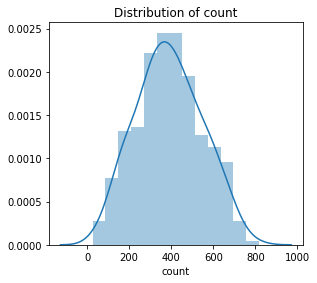

In [14]:
fig=plt.figure()
ax8=fig.add_subplot(2,2,1)
fig.set_size_inches(10,9)
sns.distplot(df_count['count'],ax=ax8)
ax8.set_title('Distribution of count')

# Observe the distribution of bike rentals to understand the difference in data.
# In order to improve the accuracy of prediction and analysis in the later stage, the data should normally distributed as far as possible.
# The count distribution in the following chart basically conforms to the required normal distribution principle.

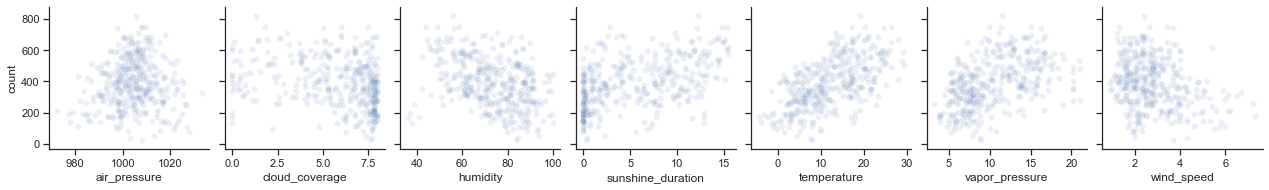

In [15]:
sns.set(style='ticks',color_codes=True)
sns.pairplot(df_count,x_vars=['air_pressure','cloud_coverage','humidity','sunshine_duration','temperature','vapor_pressure','wind_speed'],
            y_vars=['count'],plot_kws={'alpha':0.1})

### Correlation analysis between features and rental amount

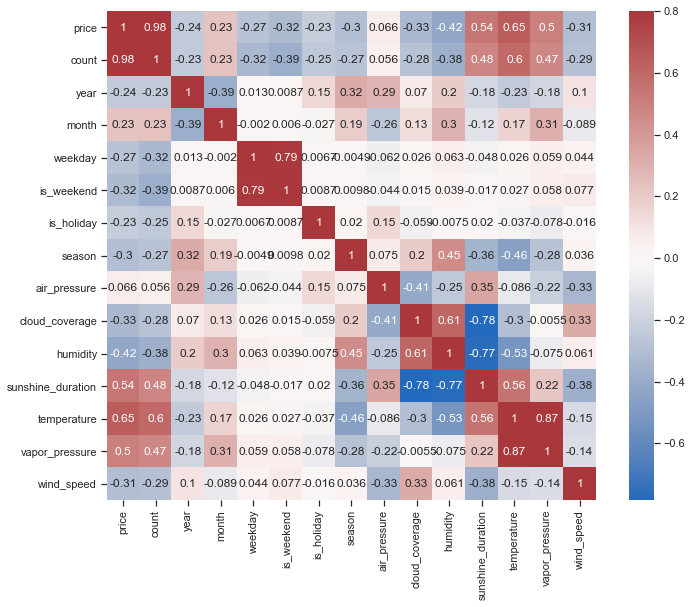

In [16]:
corrmat = df_count.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,linecolor='white',annot=True,cmap='vlag')

plt.show()

In [17]:
correlation_mat=df_count.corr()
correlation_mat["count"].sort_values(ascending=False)

# The correlation can be concluded as：
# Positive correlation: temperature>sunshine_duration>vapor_pressure>month>air_pressure
# Negative correlation: is_weekend>humidity>wind_speed>cloud_coverage>is_holiday

count                1.000000
price                0.984900
temperature          0.598862
sunshine_duration    0.478358
vapor_pressure       0.467968
month                0.231094
air_pressure         0.056075
year                -0.234361
is_holiday          -0.251411
season              -0.273314
cloud_coverage      -0.279825
wind_speed          -0.286900
weekday             -0.323983
humidity            -0.377337
is_weekend          -0.388324
Name: count, dtype: float64

### The effect of temperature on rental amount

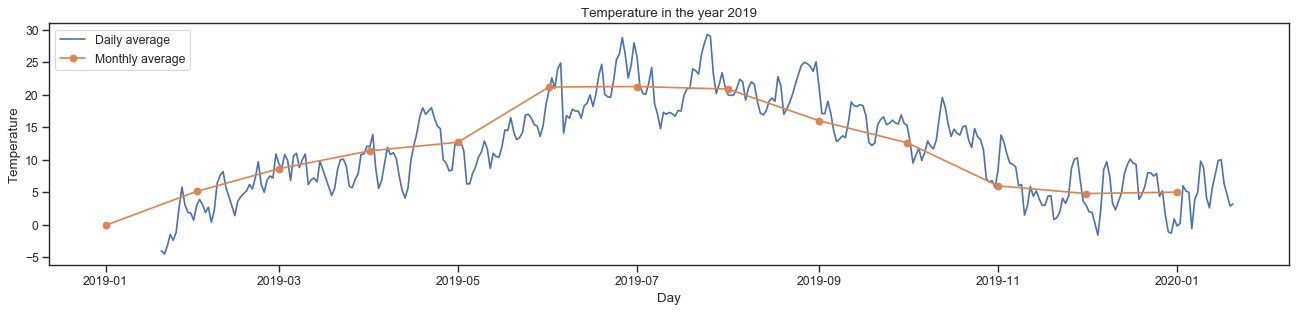

In [18]:
temperaturedf = df_count.groupby(['day'],as_index=False).agg({'temperature':'mean'})
temperaturedf['day'] = pd.to_datetime(temperaturedf['day'])

temperaturedf = temperaturedf.set_index('day')

temp_month = df_count.groupby(['year','month'],as_index=False).agg({'weekday':'min','temperature':'mean'})
temp_month.rename(columns={'weekday':'day'},inplace=True)
temp_month['day'] = pd.to_datetime(temp_month[['year','month','day']])

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)

plt.plot(temperaturedf.index,temperaturedf['temperature'],label='Daily average')
plt.plot(temp_month['day'],temp_month['temperature'],marker='o',label='Monthly average')
ax.set_xlabel('Day')
ax.set_ylabel('Temperature')
plt.legend(loc="upper left")
ax.set_title('Temperature in the year 2019')

plt.show()

# The figure below shows the trend of Mannheim's temperature during this period.

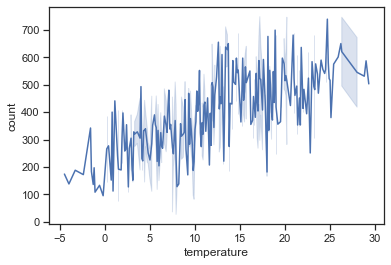

In [19]:
sns.lineplot(x='temperature',y='count',data=df_count)
# The highest temperature of the year in Mannheim is 29.3 ºC.

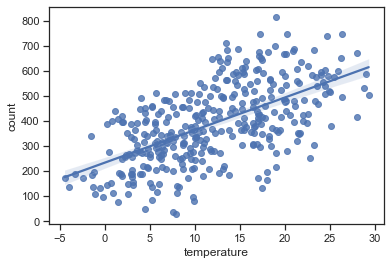

In [20]:
sns.regplot(x='temperature',y='count',data=df_count)

- The temperature is positively correlated with the rental amount of shared bikes. 
- The optimal temperature for basic travel is 20-25 ºC, and then the rental number decreases with the increase of the temperature.
- Moreover, when the temperature within 26-28 ºC, the confidence interval becomes larger, and it is assumed that there are fewer occurrences of abnormal temperature, leading to a larger standard deviation of the average rental number at this temperature.
- When the temperature is close to -2-0 ºC, the number of shared bike rental reaches the lowest.

### The effect of sunshine duration on rental amount

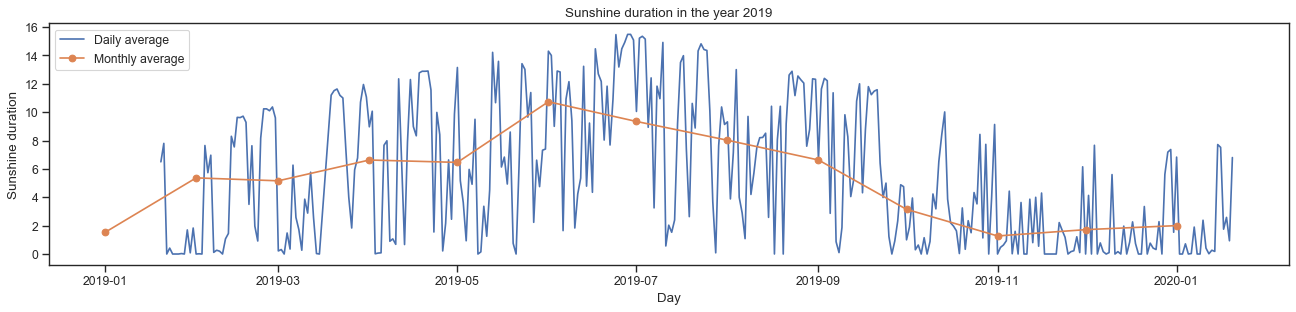

In [21]:
sunshinedurationdf = df_count.groupby(['day'],as_index=False).agg({'sunshine_duration':'mean'})
sunshinedurationdf['day'] = pd.to_datetime(sunshinedurationdf['day'])

sunshinedurationdf = sunshinedurationdf.set_index('day')

sunshine_month = df_count.groupby(['year','month'],as_index=False).agg({'weekday':'min','sunshine_duration':'mean'})
sunshine_month.rename(columns={'weekday':'day'},inplace=True)
sunshine_month['day'] = pd.to_datetime(sunshine_month[['year','month','day']])

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)

plt.plot(sunshinedurationdf.index,sunshinedurationdf['sunshine_duration'],label='Daily average')
plt.plot(sunshine_month['day'],sunshine_month['sunshine_duration'],marker='o',label='Monthly average')
ax.set_xlabel('Day')
ax.set_ylabel('Sunshine duration')
plt.legend(loc="upper left")
ax.set_title('Sunshine duration in the year 2019')

plt.show()

# The figure below shows the trend of Mannheim's sunshine duration during this period.

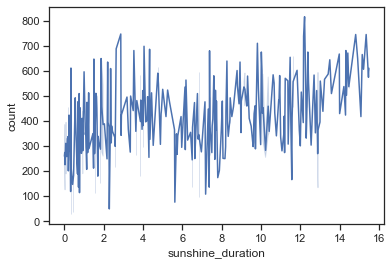

In [22]:
sns.lineplot(x='sunshine_duration',y='count',data=df_count)

- Sunshine duration is positively correlated with the number of shared bike rentals, but the degree of correlation is not very obvious. 
- When the sunshine duration is between 0-11 hours, the number of shared bicycle rentals does not change significantly, and the basic rental number does not fluctuate much, almost showing a horizontal line. 
- While the sunshine duration greater than 12 hours, the rental increases with the increase of sunshine duration. 
- The rental volume surged when sunshine duration was around 12 hours The conjecture is the impact of the relatively small amount of data, which needs to be furtherly checked.

### The effect of vapor pressure on rental amount

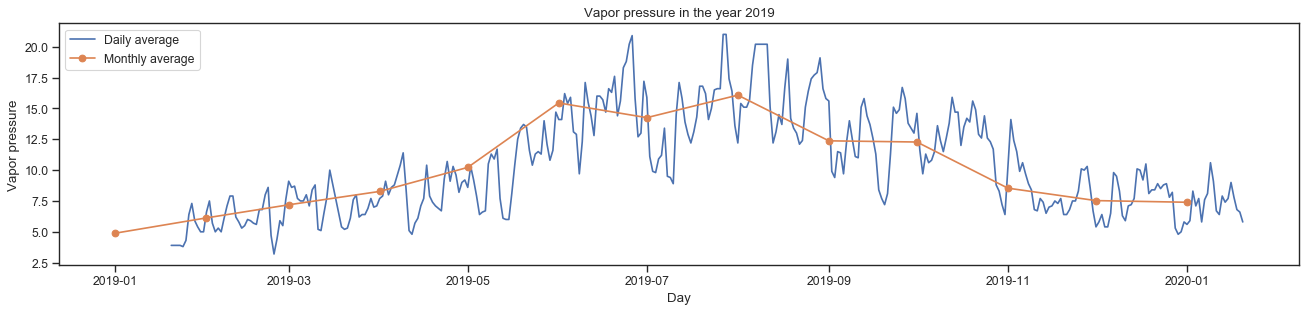

In [23]:
vaporpressuredf = df_count.groupby(['day'],as_index=False).agg({'vapor_pressure':'mean'})
vaporpressuredf['day'] = pd.to_datetime(vaporpressuredf['day'])

vaporpressuredf = vaporpressuredf.set_index('day')

vapor_month = df_count.groupby(['year','month'],as_index=False).agg({'weekday':'min','vapor_pressure':'mean'})
vapor_month.rename(columns={'weekday':'day'},inplace=True)
vapor_month['day'] = pd.to_datetime(vapor_month[['year','month','day']])

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)

plt.plot(vaporpressuredf.index,vaporpressuredf['vapor_pressure'],label='Daily average')
plt.plot(vapor_month['day'],vapor_month['vapor_pressure'],marker='o',label='Monthly average')
ax.set_xlabel('Day')
ax.set_ylabel('Vapor pressure')
plt.legend(loc="upper left")
ax.set_title('Vapor pressure in the year 2019')

plt.show()

# The figure below shows the trend of Mannheim's vapor pressure during this period.

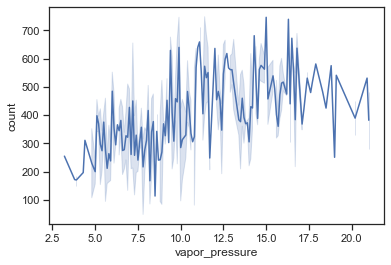

In [24]:
sns.lineplot(x='vapor_pressure',y='count',data=df_count)

- Vapor pressure is positively correlated with the rental of shared bikes. The most suitable pressure for basic travel is 15 hpa, which reaches 750 peak rentals. Subsequently, the number of rentals decreases as the pressure increases. 
- The number of shared bicycle rentals reaches the lowest when approaching 3.5 hpa.

### The effect of month on rental amount

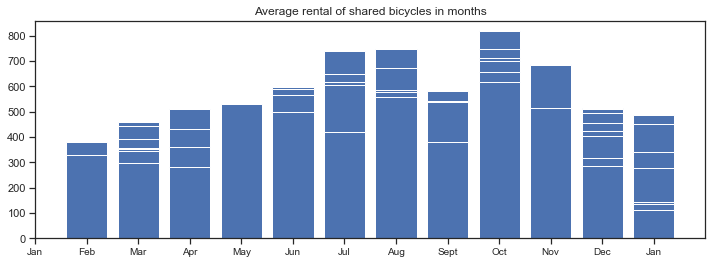

In [25]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
fig.set_size_inches(12,4)

plt.bar(df_count['month'], df_count['count'], align='center')
ax.set_title('Average rental of shared bicycles in months',fontsize=12)
ax.set_xticks(list(range(13)))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Jan'],fontsize=10)

plt.show()

- From February to October 2019, bike rentals continued to rise, despite an unusual low value in September. 
- Rental volume in February 2019 is the lowest point of the year (less than 400). In October the rental reached the highest value of 800. 
- There is a clear downward trend after October 2019, which is not a business error, but a normal decline due to natural weather changes.

### The effect of weekend on rental amount

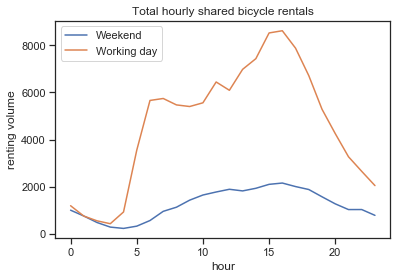

In [26]:
weekenddf1=df[df['is_weekend']==1].groupby("hour")['hour'].count()
weekenddf0=df[df['is_weekend']==0].groupby("hour")['hour'].count()

plt.plot(list(range(24)),weekenddf1, label="Weekend")
plt.plot(list(range(24)),weekenddf0, label="Working day")

plt.xlabel('hour')
plt.ylabel('renting volume')
plt.title('Total hourly shared bicycle rentals')
plt.legend(loc="upper left")

plt.show()

In [27]:
hourdf.fillna(0,inplace=True)

weekendhourdf1=hourdf[hourdf['is_weekend']==1].groupby('Date').mean()
weekendhourdf0=hourdf[hourdf['is_weekend']==0].groupby('Date').mean()

weekendhour1=np.mean(weekendhourdf1).reset_index(name='weekend')
weekendhour0=np.mean(weekendhourdf0).reset_index(name='working day')

isweekendhour = pd.merge(weekendhour1,
                         weekendhour0,
                         on='index',
                         how='outer')
isweekendhour = isweekendhour.drop([0,1])
isweekendhour = isweekendhour.reset_index(drop=True)
isweekendhour

,index,weekend,working day
0,0h,9.834951,4.623077
1,1h,7.436893,2.934615
2,2h,4.766990,2.161538
3,3h,2.883495,1.692308
4,4h,2.339806,3.603846
5,5h,3.271845,13.665385
6,6h,5.582524,21.765385
7,7h,9.359223,22.084615
8,8h,11.058252,21.038462
9,9h,13.961165,20.776923


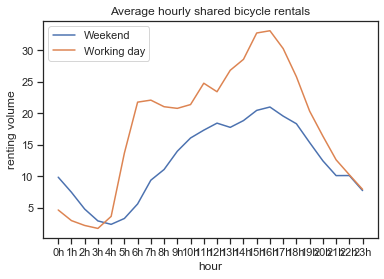

In [28]:
plt.plot(isweekendhour['index'], isweekendhour['weekend'], label='Weekend')
plt.plot(isweekendhour['index'], isweekendhour['working day'], label='Working day')

plt.xlabel('hour')
plt.ylabel('renting volume')
plt.title('Average hourly shared bicycle rentals')

plt.legend(loc="upper left")

plt.show()

- From the overall comparison of the two curves, the average bike rental trends on weekdays and weekends are basically similar, and the overall rental active time on weekends lags the working day by 2-3 hours.
- The average bike rentals on weekdays and weekends peaked at around 16:00-17:00 and reached a trough at 3:00-4:00am.

**On working days:**
- On weekdays, the average number of shared bike rentals per hour reached two peaks, about 6:00-7:00am in the morning (average 23 rentals per hour), and 16:00-17:00 (average 34 rentals per hour), these two points are exactly the peak rush hour.

**On non-working days:** 
- The commuting time on non-working days is basically concentrated between 10:00 and 18:00. At this time, the use of shared bicycles is relatively large. On weekdays, this time is basically the time for working, thus the use of bikes is less. 
- The average bike rental on non-working days is significantly higher than that on weekdays from 0:00 to 3:00, which may be caused by the late return on weekends.

### The effect of holiday on rental amount

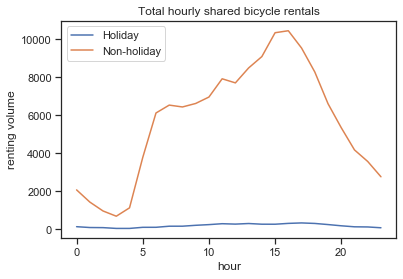

In [29]:
holidaydf1=df[df['is_holiday']==1].groupby("hour")['hour'].count()
holidaydf0=df[df['is_holiday']==0].groupby("hour")['hour'].count()

plt.plot(list(range(24)),holidaydf1, label="Holiday")
plt.plot(list(range(24)),holidaydf0, label="Non-holiday")

plt.xlabel('hour')
plt.ylabel('renting volume')
plt.title('Total hourly shared bicycle rentals')
plt.legend(loc="upper left")

plt.show()

In [30]:
holidayhourdf1=hourdf[hourdf['is_holiday']==1].groupby('Date').mean()
holidayhourdf0=hourdf[hourdf['is_holiday']==0].groupby('Date').mean()

holidayhour1=np.mean(holidayhourdf1).reset_index(name='holiday')
holidayhour0=np.mean(holidayhourdf0).reset_index(name='non-holiday')

isholidayhour = pd.merge(holidayhour1,
                         holidayhour0,
                         on='index',
                         how='outer')

isholidayhour = isholidayhour.drop([0,1])
isholidayhour = isholidayhour.reset_index(drop=True)

isholidayhour

,index,holiday,non-holiday
0,0h,6.90,6.055394
1,1h,4.70,4.183673
2,2h,4.40,2.813411
3,3h,2.35,2.011662
4,4h,2.35,3.297376
5,5h,5.25,11.034985
6,6h,5.30,17.865889
7,7h,8.15,19.075802
8,8h,8.20,18.790087
9,9h,10.55,19.326531


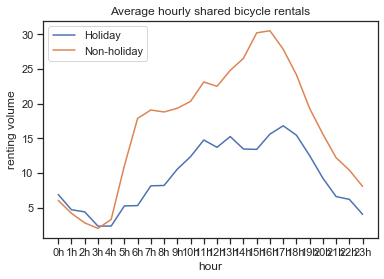

In [31]:
plt.plot(isholidayhour['index'], isholidayhour['holiday'], label='Holiday')
plt.plot(isholidayhour['index'], isholidayhour['non-holiday'], label='Non-holiday')

plt.xlabel('hour')
plt.ylabel('renting volume')
plt.title('Average hourly shared bicycle rentals')
plt.legend(loc="upper left")

plt.show()

- Holidays include weekends if statutory holidays are nearing the weekend.
- The number of commuters on holidays mostly concentrated from 10:00 to 19:00.
- Non-holiday commuting is mostly around 6:00-18:00.
- In both cases, the rental volume reached its peak within a day at around 17:00.

### The effect of weekday on rental amount

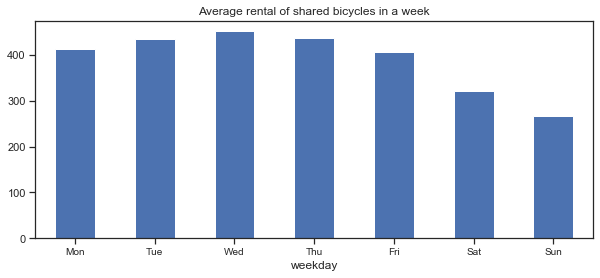

In [32]:
weekdaydf=df_count.groupby(['weekday'])['count'].mean()

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
fig.set_size_inches(10,4)

weekdaydf.plot(kind='bar',ax=ax)
ax.set_title('Average rental of shared bicycles in a week',fontsize=12)
ax.set_xticks(list(range(7)))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=10,rotation=0)

plt.show()

- There is basically no significant change in the usage of bikes from Monday to Friday, while the rental reduced on Saturdays and Sundays.
- Bike rental peaked on Wednesday at about 450.

### The effect of season on rental amount

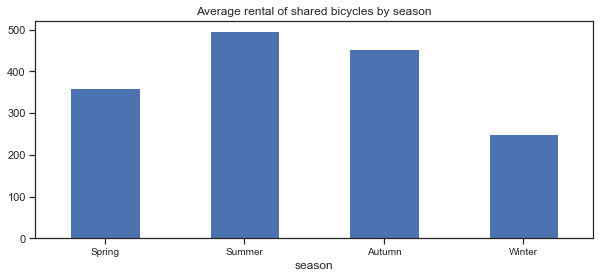

In [33]:
seasondf=df_count.groupby(['season'])['count'].mean()
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
fig.set_size_inches(10,4)

seasondf.plot(kind='bar',ax=ax)
ax.set_title('Average rental of shared bicycles by season',fontsize=12)
ax.set_xticks(list(range(4)))
ax.set_xticklabels(['Spring','Summer','Autumn','Winter'],fontsize=10,rotation=0)

plt.show()

The number of shared bike rentals in spring and winter is relatively small compared to the other two seasons, of which the rental in winter is the least and only half of that in summer.

### KPI Indicators for daily monitoring

#### KPI 1: City Coverage & Bike Activity Scope

In [34]:
from math import cos, sin, atan2, sqrt, pi ,radians, degrees

def center_geolocation(geolocations):        
    x = 0    
    y = 0    
    z = 0    
    lenth = len(geolocations)    
    for lon, lat in geolocations:        
        lon = radians(float(lon))        
        lat = radians(float(lat))              
        
        x += cos(lat) * cos(lon)        
        y += cos(lat) * sin(lon)        
        z += sin(lat)     
        
        x = float(x / lenth)   
        y = float(y / lenth)   
        z = float(z / lenth)     
        
        return (degrees(atan2(y, x)), degrees(atan2(z, sqrt(x * x + y * y))))

In [35]:
locationdestdf = pd.DataFrame({'lat':df['dest_lat'],
                           'lng':df['dest_lng']})
locationdestdf = locationdestdf.values.tolist()

print("Bike Activity Scope Center: ",center_geolocation(locationdestdf))


def geodistance(lat1,lng1,lat2,lng2):
    
    lat1, lng1, lat2, lngt2 = map(radians, [float(lat1), float(lng1), float(lat2), float(lng2)])
    dlat=lat2-lat1
    dlng=lng2-lng1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2 
    distance=2 * sin(sqrt(a)) * 6371 * 1000 
    distance=round(distance/1000,3)
    return distance

print('The coverage radius of the bikes is:',geodistance(df['dest_lat'].mean(), df['dest_lng'].mean(), 49.49894614, 8.46722424),'m')

Bike Activity Scope Center:  (49.49894614, 8.46722424)
The coverage radius of the bikes is: 6690.865 m


#### KPI 2: Bike Utilization Rate

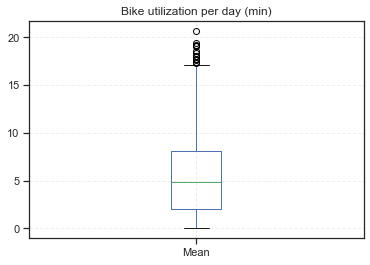

count    1104.000000
mean        5.599891
std         4.303335
min         0.000000
25%         1.990000
50%         4.835000
75%         8.092500
max        20.670000
Name: Mean, dtype: float64

In [36]:
bike_utilization.fillna(0,inplace=True)

bikeutidf = bike_utilization['Mean']
bikeutidf.plot.box(title="Bike utilization per day (min)")
plt.grid(linestyle="--", alpha=0.3)

plt.show()
bikeutidf.describe()

# Total minutes that a bike was being occupied in a year / Total number of days

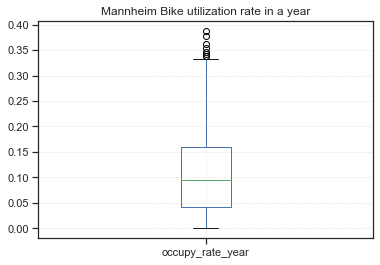

count    1104.000000
mean        0.108378
std         0.079737
min         0.000000
25%         0.041000
50%         0.094000
75%         0.160000
max         0.388000
Name: occupy_rate_year, dtype: float64

In [37]:
bikeutiratedf = bike_utilization['occupy_rate_year']
bikeutiratedf.plot.box(title="Mannheim Bike utilization rate in a year")
plt.grid(linestyle="--", alpha=0.3)

plt.show()
bikeutiratedf.describe()

# Total days that a bike was being occupied in a year / Total number of days

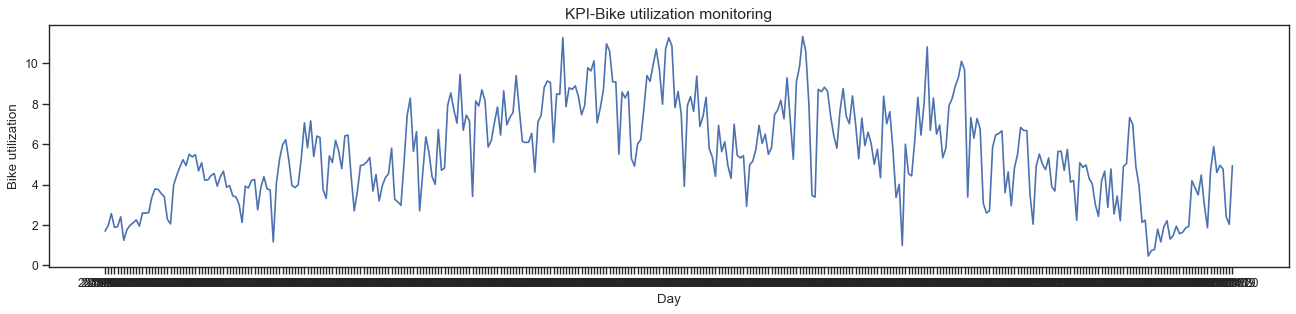

In [38]:
kpiutilization = bike_utilization.iloc[1103]
kpiutilization = kpiutilization.to_frame()
kpiutilization.drop(['index','b-number','Grand Total','Mean','occupy_day','occupy_rate_year'],inplace=True)

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)
ax.plot(kpiutilization)
plt.xlabel('Day')
plt.ylabel('Bike utilization')
plt.title('KPI-Bike utilization monitoring',fontsize=14)

plt.show()

# The daily curve of shared bike utilization, which can be used for real-time monitoring.

#### KPI 3: Daily Operating Revenue

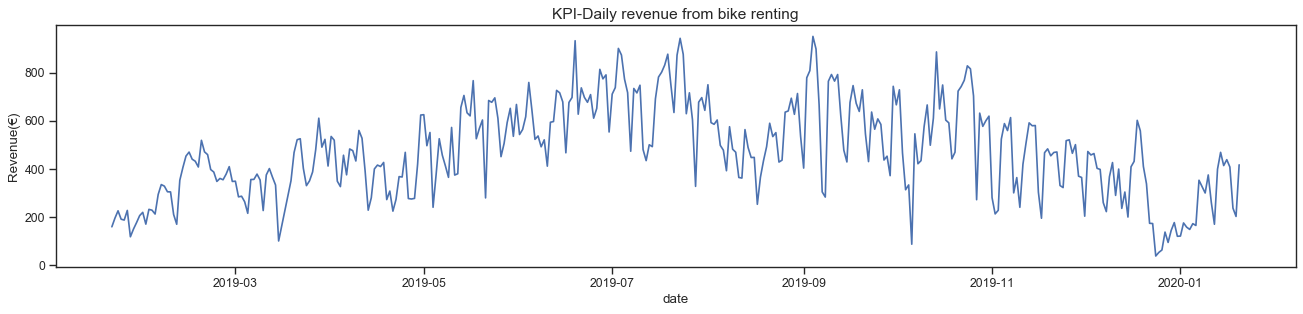

In [39]:
fig,ax = plt.subplots(figsize=(20,4),dpi=80)

ax = sns.lineplot(x='day', y='price',data=df_count)
 
plt.title('KPI-Daily revenue from bike renting',fontsize=14)
plt.xlabel('date')
plt.ylabel('Revenue(€)')
 
plt.show()

### Predictive analysis

After understanding the basic relationship between variables through the above data, the following starts to monitor, model and predict the data in real-time basis.

#### 1. Linear regression - OLS

In [40]:
reg1=smf.ols('count~temperature',data=df_count).fit()
print(reg1.summary())
# p-value=0, which means the effect of temperature feature is significant. However that R2 model fit is not enough (0.359).

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     201.9
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           1.06e-36
Time:                        13:44:08   Log-Likelihood:                -2268.7
No. Observations:                 363   AIC:                             4541.
Df Residuals:                     361   BIC:                             4549.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     233.9877     12.836     18.229      

In [41]:
reg2 = smf.ols('count~temperature+is_weekend',data=df_count).fit()
print(reg2.summary())
# Add is_weekend feature. p-value=0，the effect is also significant. R2 enhances obviously.

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     196.7
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           1.87e-58
Time:                        13:44:08   Log-Likelihood:                -2215.3
No. Observations:                 363   AIC:                             4437.
Df Residuals:                     360   BIC:                             4448.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     271.0244     11.586     23.393      

In [42]:
reg3 = smf.ols('count~temperature+is_weekend+month+vapor_pressure+is_holiday+weekday+season+humidity+air_pressure',data=df_count).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     67.29
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           3.54e-71
Time:                        13:44:09   Log-Likelihood:                -2168.0
No. Observations:                 363   AIC:                             4356.
Df Residuals:                     353   BIC:                             4395.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2328.8534    606.272     -3.

In [43]:
# Predict the trend of bicycle rentals through the maximum correlation variable - temperature.
# Randomly select 30% of the data to construct test samples, and the rest as training samples.

#X = np.array(df_count['temperature']).reshape(-1,2)
X = df_count[['temperature','weekday','month','is_weekend','vapor_pressure','air_pressure']]
X = np.array(X).reshape(-1,6)
y = np.array(df_count['count']).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=60, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_y_pred = lr.predict(X_test)

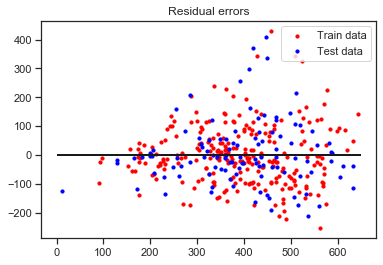

In [44]:
# plotting residual errors in training data
plt.scatter(lr.predict(X_train), lr.predict(X_train) - y_train, color = 'red', s = 10, label = 'Train data') 

# plotting residual errors in test data 
plt.scatter(lr.predict(X_test), lr.predict(X_test) - y_test, color = 'blue', s = 10, label = 'Test data') 

## plotting line for zero residual error 
plt.hlines(y = 0, xmin = 0, xmax = 650, linewidth = 2) 

plt.legend(loc = 'upper right') 
plt.title("Residual errors") 
plt.show() 

In [45]:
from sklearn.preprocessing import StandardScaler

# Analyze some features of the regression target value and observe the fluctuation range of the rental volume. 
# If the difference is too large, it needs to be standardized.

ss_X=StandardScaler()   
ss_y=StandardScaler()

X_train=ss_X.fit_transform(X_train)
X_test=ss_X.transform(X_test)
y_train=ss_y.fit_transform(y_train.reshape(-1, 1))
y_test=ss_y.transform(y_test.reshape(-1, 1))

lr.fit(X_train,y_train)
lr_y_pred=lr.predict(X_test)

print("The value of default measurement of LinearRegression is",lr.score(X_test,y_test))
print("The value of R_suqared of LinearRegression is",r2_score(y_test,lr_y_pred))
print("The mean squared error of LinearRegression is",
      mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(lr_y_pred)))   
#inverse_transform is used to restore real results
print("The mean absolute error of LinearRegression is",
      mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(lr_y_pred)))

The value of default measurement of LinearRegression is 0.5240814842029651
The value of R_suqared of LinearRegression is 0.5240814842029651
The mean squared error of LinearRegression is 12457.034922469527
The mean absolute error of LinearRegression is 79.67235516960423


#### 2. Linear regression - SGD

In [46]:
sgdr=SGDRegressor()
sgdr.fit(X_train,y_train)
sgdr_y_pred=sgdr.predict(X_test)

print("The value of default measurement of SGDRegressor is",sgdr.score(X_test,y_test))
print("The value of R_suqared of SGDRegression is",r2_score(y_test,sgdr_y_pred))
print("The mean squared error of SGDRegression is",
      mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(sgdr_y_pred)))
print("The mean absolute error of SGDRegression is",
      mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(sgdr_y_pred)))

The value of default measurement of SGDRegressor is 0.49333658103757894
The value of R_suqared of SGDRegression is 0.49333658103757894
The mean squared error of SGDRegression is 13261.774220703712
The mean absolute error of SGDRegression is 81.975859542084


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


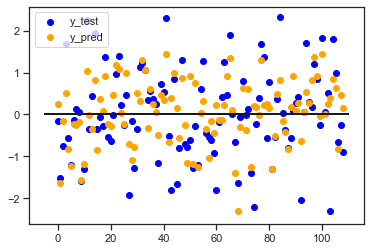

In [47]:
plt.scatter(np.arange(len(y_test)),y_test,color = 'blue',label='y_test')
plt.scatter(np.arange(len(sgdr_y_pred)),sgdr_y_pred,color = 'orange',label='y_pred')
plt.hlines(y = 0, xmin = -5, xmax = 110, linewidth = 2) 
plt.legend(loc=2)
plt.show()

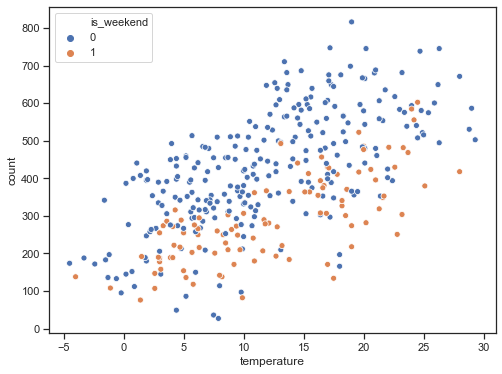

In [48]:
plt.figure(figsize = (8,6))

sns.scatterplot(x=df_count['temperature'], y=df_count['count'], hue=df_count['is_weekend'])
plt.show()

In [49]:
X = df_count[['temperature', 'is_weekend']]
y = df_count['count'].values.reshape(-1,1)
mlr = LinearRegression()
mlr.fit(X,y)
print(mlr.coef_, mlr.intercept_)

[[  13.24789737 -140.42450144]] [271.02444605]


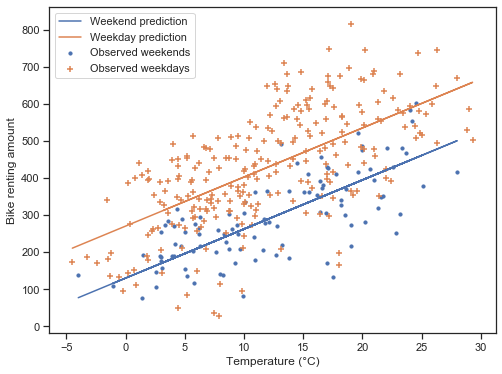

In [50]:
X_weekend = X[X['is_weekend']==1]
X_weekday = X[X['is_weekend']==0]

# predict weekends and weekdays seperately
y_pred_weekend = mlr.predict(X_weekend)
y_pred_weekday = mlr.predict(X_weekday)

plt.figure(figsize = (8,6))

plt.scatter(X_weekend['temperature'], df_count[df_count['is_weekend']==True]['count'], 
            marker='o',s=10,label='Observed weekends')

plt.scatter(X_weekday['temperature'], df_count[df_count['is_weekend']==False]['count'], 
            marker='+',label='Observed weekdays')

plt.plot(X_weekend['temperature'], y_pred_weekend, label='Weekend prediction')
plt.plot(X_weekday['temperature'], y_pred_weekday, label="Weekday prediction")

plt.xlabel('Temperature (°C)')
plt.ylabel('Bike renting amount')

plt.legend()
plt.show()

In [51]:
# 1v means one variance
y = df_count['count']
X_1v = df_count['temperature'].values.reshape((-1,1))
X_2v = df_count[['temperature', 'is_weekend']]

# make predictions
mlr1v = LinearRegression()
mlr2v = LinearRegression()
mlr1v.fit(X_1v,y)
mlr2v.fit(X_2v,y)

y_pred_1v = mlr1v.predict(X_1v)
y_pred_2v = mlr2v.predict(X_2v)

print('The main absolute error of MLR-weekend:', mean_absolute_error(y,y_pred_1v))
print('The main absolute error of MLR-weekday:', mean_absolute_error(y,y_pred_2v))

print('The main squared error of MLR-weekend:', mean_squared_error(y,y_pred_1v)**0.5)
print('The main squared error of MLR-weekday:', mean_squared_error(y,y_pred_2v)**0.5)

print('The value of R_suqared of MLR-weekend:', r2_score(y,y_pred_1v))
print('The value of R_suqared of MLR-weekday:', r2_score(y,y_pred_2v))

The main absolute error of MLR-weekend: 101.18700017428509
The main absolute error of MLR-weekday: 86.03796478269773
The main squared error of MLR-weekend: 125.32858750902213
The main squared error of MLR-weekday: 108.17807736914301
The value of R_suqared of MLR-weekend: 0.35863610516481137
The value of R_suqared of MLR-weekday: 0.5221597434791201


#### 3. Decision tree regression

In [52]:
y = df_count['count'].values
X = df_count.drop(['count','price','day','city'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("X_train_shape:", X_train.shape, " y_train_shape:", y_train.shape)
print("X_test_shape:", X_test.shape,"  y_test_shape:", y_test.shape)

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
print("train score:", tree.score(X_train, y_train))
print("test score:", tree.score(X_test, y_test))

X_train_shape: (254, 13)  y_train_shape: (254,)
X_test_shape: (109, 13)   y_test_shape: (109,)
train score: 1.0
test score: 0.6179293006194237


In [53]:
def cv_score(d):
    tree = DecisionTreeRegressor(max_depth=d)
    tree.fit(X_train, y_train)
    return(tree.score(X_train, y_train), tree.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
depths = np.arange(1,10)
scores = [cv_score(d) for d in depths]
tr_scores = [s[0] for s in scores]
te_scores = [s[1] for s in scores]

# Find out the index with the highest score in the Cross-validation dataset
tr_best_index = np.argmax(tr_scores)
te_best_index = np.argmax(te_scores)

print("bestdepth:", te_best_index+1, " bestdepth_score:", te_scores[te_best_index], '\n')

bestdepth: 6  bestdepth_score: 0.693703676704819 



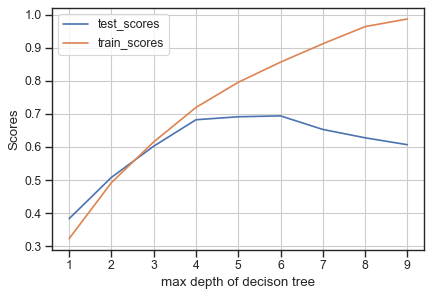

In [54]:
depths = np.arange(1,10)
plt.figure(figsize=(6,4), dpi=80)
plt.grid()
plt.xlabel('max depth of decison tree')
plt.ylabel('Scores')
plt.plot(depths, te_scores, label='test_scores')
plt.plot(depths, tr_scores, label='train_scores')
plt.legend()

In [55]:
rf_regressor = ensemble.RandomForestRegressor(max_depth=te_best_index+1, n_estimators=100)
rf_regressor.fit(X_train, y_train)

importance = rf_regressor.feature_importances_
y_test_pred = rf_regressor.predict(X_test)
print(metrics.r2_score(y_test, y_test_pred))

0.7759440312212545


[10  2  1 11  3  9  5  8 12  4  7  6  0]


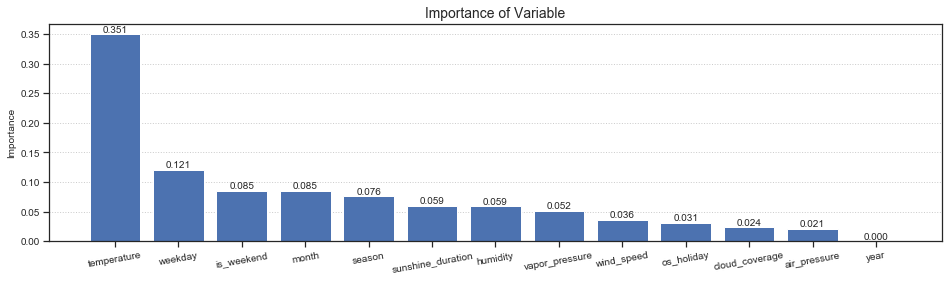

In [56]:
df_count_features = df_count.drop(['count','price','day','city'],axis=1)

fig=plt.figure()
fig.set_size_inches(16,4)

plt.subplot(1,1,1)
plt.title('Importance of Variable', fontsize=14)
plt.ylabel('Importance', fontsize=10)
plt.tick_params(labelsize=10)
plt.grid(axis='y', linestyle=':')
sorted_indices = importance.argsort()[::-1]
print(sorted_indices)
pos = np.arange(sorted_indices.size)
plt.bar(pos, importance[sorted_indices])
plt.xticks(range(13),('temperature','weekday','is_weekend','month','season','sunshine_duration','humidity',
            'vapor_pressure','wind_speed','os_holiday','cloud_coverage','air_pressure','year'),rotation=10)
for a,b in zip(pos,importance[sorted_indices]):
    plt.text(a, b, '%.3f' % b, ha='center', va= 'bottom',fontsize=10)

plt.show()

In [57]:
df_lr_data = df_count.loc[:,['temperature','is_weekend','month','is_holiday','vapor_pressure']]
df_lr_target = df_count.loc[:,['count']]
x = df_lr_data.values
y = df_lr_target.values

In [58]:
x,y = make_blobs(n_samples=300, n_features=2, centers=6)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, train_size=0.7)

clf1 = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
clf2 = RandomForestClassifier(n_estimators=10,max_features=math.sqrt(2), max_depth=None,min_samples_split=2, bootstrap=True)
clf3 = ExtraTreesClassifier(n_estimators=10,max_features=math.sqrt(2), max_depth=None,min_samples_split=2, bootstrap=False)

scores1 = cross_val_score(clf1, x_train, y_train)
scores2 = cross_val_score(clf2, x_train, y_train)
scores3 = cross_val_score(clf3, x_train, y_train)

print('DecisionTreeClassifier cross-validation accuracy:'+str(scores1.mean()))    
print('RandomForestClassifier cross-validation accuracy:'+str(scores2.mean()))    
print('ExtraTreesClassifier cross-validation accuracy:'+str(scores3.mean()))

DecisionTreeClassifier cross-validation accuracy:0.9476190476190476
RandomForestClassifier cross-validation accuracy:0.9571428571428571
ExtraTreesClassifier cross-validation accuracy:0.9428571428571428


In [59]:
clf1.fit(x_train, y_train)
clf2.fit(x_train, y_train)
clf3.fit(x_train, y_train)

x1_min, x1_max = x[:, 0].min(), x[:, 0].max()            # range of column 0
x2_min, x2_max = x[:, 1].min(), x[:, 1].max()            # range of column 1
x1, x2 = np.mgrid[x1_min:x1_max:200j, x2_min:x2_max:200j]# generate grid sampling points: both rows and columns are 200
area_smaple_point = np.stack((x1.flat, x2.flat), axis=1) # divide the area into a series of test points and predict, then draw the area based on the prediction result
area1_predict = clf1.predict(area_smaple_point)          # predict all points
area1_predict = area1_predict.reshape(x1.shape) 


area2_predict = clf2.predict(area_smaple_point)          
area2_predict = area2_predict.reshape(x1.shape)

area3_predict = clf3.predict(area_smaple_point)          
area3_predict = area3_predict.reshape(x1.shape)
  
mpl.rcParams['axes.unicode_minus'] = False               # used to display negative signs normally

classifier_area_color = mpl.colors.ListedColormap(['#A0FFA0', '#FFA0A0', '#A0A0FF'])  # area color
cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])                                  # color of sample category

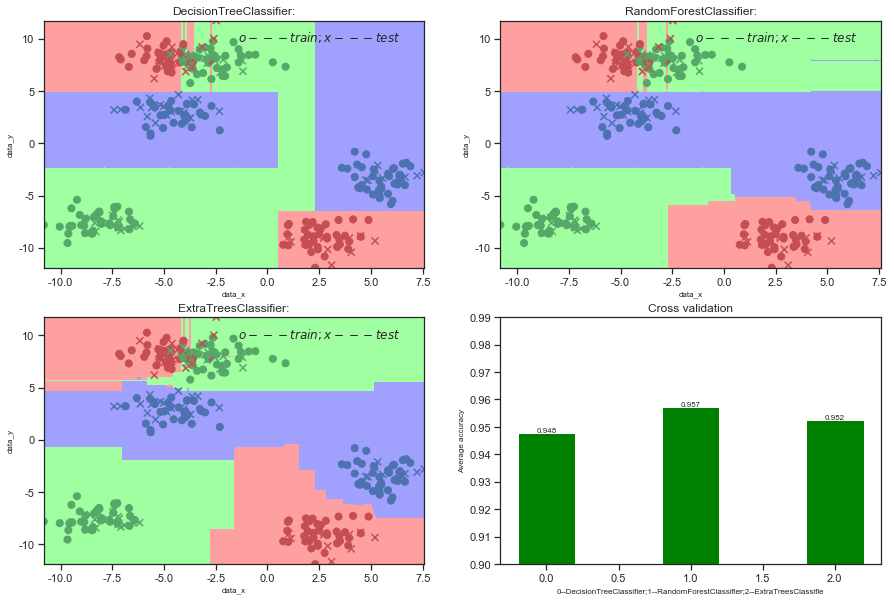

In [60]:
fig=plt.figure()
fig.set_size_inches(15,10)

plt.subplot(2,2,1) 
plt.pcolormesh(x1, x2, area1_predict, cmap=classifier_area_color)                        
plt.scatter(x_train[:,0], x_train[:,1], c=y_train,marker='o', s=50, cmap=cm_dark)    
plt.scatter(x_test[:,0],x_test[:,1], c=y_test,marker='x', s=50, cmap=cm_dark) 
plt.xlabel('data_x', fontsize=8)  
plt.ylabel('data_y', fontsize=8)
plt.xlim(x1_min, x1_max)  
plt.ylim(x2_min, x2_max)
plt.title(u'DecisionTreeClassifier:', fontsize=12)
plt.text(x1_max-9, x2_max-2, u'$o---train ; x---test$')

plt.subplot(2,2,2) 
plt.pcolormesh(x1, x2, area2_predict, cmap=classifier_area_color)                        
plt.scatter(x_train[:,0], x_train[:,1], c=y_train,marker='o', s=50, cmap=cm_dark)    
plt.scatter(x_test[:,0],x_test[:,1], c=y_test,marker='x', s=50, cmap=cm_dark) 
plt.xlabel('data_x', fontsize=8)  
plt.ylabel('data_y', fontsize=8)
plt.xlim(x1_min, x1_max)  
plt.ylim(x2_min, x2_max)
plt.title(u'RandomForestClassifier:', fontsize=12)
plt.text(x1_max-9,x2_max-2, u'$o---train ; x---test$')

plt.subplot(2,2,3) 
plt.pcolormesh(x1, x2, area3_predict, cmap=classifier_area_color)                        
plt.scatter(x_train[:,0], x_train[:,1], c=y_train,marker='o', s=50, cmap=cm_dark)    
plt.scatter(x_test[:,0],x_test[:,1], c=y_test,marker='x', s=50, cmap=cm_dark) 
plt.xlabel('data_x', fontsize=8)  
plt.ylabel('data_y', fontsize=8)
plt.xlim(x1_min, x1_max)  
plt.ylim(x2_min, x2_max)
plt.title(u'ExtraTreesClassifier:', fontsize=12)
plt.text(x1_max-9, x2_max-2, u'$o---train ; x---test$') 

plt.subplot(2,2,4)
y=[]
scores1 = cross_val_score(clf1, x_train, y_train)
y.append(scores1.mean())
scores2 = cross_val_score(clf2, x_train, y_train)
y.append(scores2.mean())
scores3 = cross_val_score(clf3, x_train, y_train)
y.append(scores3.mean())

x=[0,1,2]
plt.bar(x,y,0.4,color="green")  
plt.xlabel("0--DecisionTreeClassifier;1--RandomForestClassifier;2--ExtraTreesClassifie", fontsize=8)  
plt.ylabel("Average accuracy", fontsize=8)
plt.ylim(0.9, 0.99)
plt.title("Cross validation",fontsize=12)
for a, b in zip(x, y):      
    plt.text(a, b,'%.3f'% b, ha='center', va='bottom', fontsize=8) 

plt.show()

#### 4. Lasso regression

In [61]:
X = df_count[['month','weekday','is_weekend','temperature','sunshine_duration','vapor_pressure','wind_speed']]
Y = df_count[['count']]
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=42,train_size=0.7)

lasso = Lasso().fit(X_train,y_train)
lasso001 = Lasso(alpha=0.01).fit(X_train,y_train)
lasso00001 = Lasso(alpha=0.0001).fit(X_train,y_train)

In [62]:
print("Lasso alpha=1")
print ("training set score:{:.2f}".format(lasso.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso.coef_!=0)))

print('**********************************')
print("Lasso alpha=0.01")
print ("training set score:{:.2f}".format(lasso001.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso00001.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso001.coef_!=0)))

print('**********************************')
print("Lasso alpha=0.0001")
print ("training set score:{:.2f}".format(lasso00001.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso00001.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso00001.coef_!=0)))

Lasso alpha=1
training set score:0.60
test set score:0.53
Number of features used:7
**********************************
Lasso alpha=0.01
training set score:0.60
test set score:0.53
Number of features used:7
**********************************
Lasso alpha=0.0001
training set score:0.60
test set score:0.53
Number of features used:7


In [63]:
predict = lasso.predict(X_train)
print('Coefficients: ', lasso.coef_, '\nIntercept: ', lasso.intercept_ )

Coefficients:  [  10.28695104   -7.1956458  -112.04089764   10.6459271     4.11006485
   -1.71265929  -15.26344546] 
Intercept:  [295.21335928]


101.5515545989003

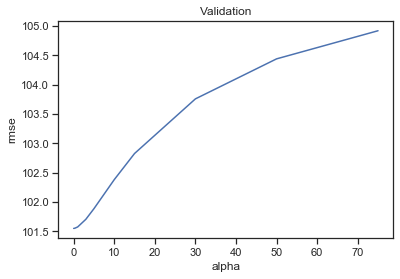

In [64]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, 
                                   scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# Pick the best alpha through the Lasso model
alphas = [0.0001, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]  

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min() 

In [65]:
# View Lasso regression coefficients

model_lasso = lasso00001
coef = pd.Series(model_lasso.coef_, index = X_train.columns)   
  
print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")

coef

Lasso picked 7 variables and eliminated the other 0 variables


month                 10.369138
weekday               -5.608423
is_weekend          -122.134903
temperature           10.979335
sunshine_duration      3.934790
vapor_pressure        -2.270992
wind_speed           -16.027951
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

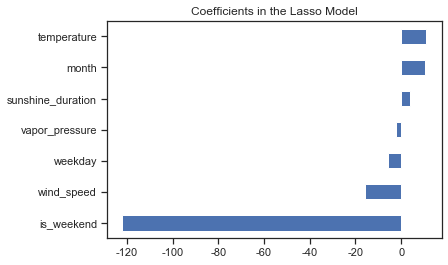

In [66]:
# Visualize Lasso regression coefficients 

imp_coef = pd.concat([coef.sort_values()])
mpl.rcParams['figure.figsize'] = (6,4)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


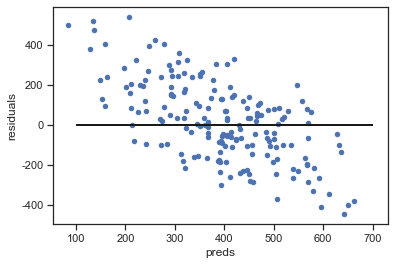

In [67]:
# View the difference between the predicted value and the true value
# Look at the residuals as well

mpl.rcParams['figure.figsize'] = (6,4)

preds = pd.DataFrame({'preds':model_lasso.predict(X_train)})
preds['true'] = y_train
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals',kind = 'scatter')
plt.hlines(y = 0, xmin = 100, xmax = 700, linewidth = 2) 